## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices
* slide inference

In [31]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW
import torch.nn.functional as F


import datetime

top-5 models

- score 0.68: https://www.kaggle.com/code/viktorcikojevic/2-5d-segmentaion-baseline-512-v1#model

"/kaggle/input/25d-segmentaion-baseline-training-models/image-512-weighted-loss-v2/image-512-weighted-loss-v2/resnet34_3d_seg_best_0.960.pt"


- score 0.66: https://www.kaggle.com/code/viktorcikojevic/2-5d-segmentaion-baseline-768?scriptVersionId=131305396

"/kaggle/input/25d-segmentaion-baseline-training-models/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/resnet18_3d_seg_best_0.5364.pt"


- score 0.65 : https://www.kaggle.com/code/viktorcikojevic/fork-of-2-5d-segmentaion-baseline-256#model

"/kaggle/input/25d-segmentaion-baseline-training-models/exp-1-reproduce-training-with-augm-bce-dice-loss/exp-1-reproduce-training-with-augm-bce-dice-loss/resnet18_3d_seg_best_0.5526.pt"

- score 0.58: https://www.kaggle.com/code/viktorcikojevic/focal-loss-ensemble-1#model (V2)

"/kaggle/input/25d-segmentaion-baseline-training-models/focal-loss-folds/focal-loss-folds/resnet18_3d_seg_best_0.5512-fold-1.pt"

- score 0.51: https://www.kaggle.com/code/viktorcikojevic/2-5d-segmentaion-baseline-1024#model

https://www.kaggle.com/code/viktorcikojevic/2-5d-segmentaion-baseline-1024#model

"/kaggle/input/25d-segmentaion-baseline-training-models/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768-cont-1024/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768-cont-1024/resnet18_3d_seg_best_0.5594.pt"





In [32]:
import zarr

FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

In [33]:
import segmentation_models_pytorch as smp

In [34]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [35]:
sys.path.append("./resnet3d")
from resnet3d import generate_model

## config

In [36]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    
    num_workers = 1
    
    in_chans = 20 # 65
    # ============== training cfg =============
    crop_size = 256
    image_size = 256
    stride = image_size // 2

    batch_size = 4
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


## helper

In [ ]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## model

In [301]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self, model_depth):
        super().__init__()
        self.encoder = generate_model(model_depth=model_depth, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

## main

In [516]:
from collections import OrderedDict


def get_pred_mask(fragment, binary_mask, crop_size, image_size, model_depth, model_weights, threshold, n_channels, model_indx):
    
    
    
    CFG.crop_size = crop_size
    CFG.image_size = image_size
    CFG.stride = image_size // 5
    CFG.model_depth = model_depth
    CFG.threshold = threshold

    CFG.batch_size = 2

    # pad with zeros to make the image dividable into tiles
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    pad0 = (CFG.crop_size - binary_mask.shape[0] % CFG.crop_size)
    pad1 = (CFG.crop_size - binary_mask.shape[1] % CFG.crop_size)
    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = np.zeros(binary_mask.shape)
    mask_count = np.zeros(binary_mask.shape)

    x1_list = list(range(0, fragment.shape[1]-CFG.crop_size+1, CFG.stride))
    y1_list = list(range(0, fragment.shape[0]-CFG.crop_size+1, CFG.stride))

    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.crop_size
            x2 = x1 + CFG.crop_size

            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
    
    
    
    model = SegModel(model_depth)
    # load model_weights
    state_dict = torch.load(model_weights)
    
     
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if 'module' in k:
            k = k.replace('module.', '')
        new_state_dict[k] = v
    model.load_state_dict(new_state_dict)
    model = model.to(CFG.device)
    model.eval()
    
    
    valid_aug_list = [
            A.Resize(CFG.image_size, CFG.image_size),
            A.Normalize(
                mean= [0] * n_channels,
                std= [1] * n_channels
            ),
            ToTensorV2(transpose_mask=True),
        ]
    # Create the augmentation pipeline
    augmentations = A.Compose(valid_aug_list)
    
    
    
    
    for xy in tqdm(xyxys, total=len(xyxys)): #tqdm(enumerate(xyxys), total=len(xyxys)):
        x1, y1, x2, y2 = xy
        
        if model_indx == 0 or model_indx == 3 or model_indx == 4:
            image = fragment[y1:y2, x1:x2] / 255
            augmented = augmentations(image=image)
            image = augmented["image"]
            image = image.unsqueeze(0).unsqueeze(0).float()
            image = image.to(CFG.device)
        if model_indx == 1 or model_indx == 2:
            frag_crop = fragment[y1:y2, x1:x2]
            frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
            frag_crop = frag_crop/65535.0
            image = frag_crop
            image = image.unsqueeze(0).float()
            image = image.to(CFG.device)
        
        
        with torch.no_grad():
            y_preds = model(image)
            torch.sigmoid_(y_preds)
            

        mask_pred[y1:y2, x1:x2] += y_preds.squeeze().to('cpu').numpy()
        mask_count[y1:y2, x1:x2] += np.ones((CFG.crop_size, CFG.crop_size))

    mask_pred = mask_pred[:ori_h, :ori_w] 
    mask_count = mask_count[:ori_h, :ori_w]
    
    mask_pred = mask_pred / mask_count
    return mask_pred
    
    
    

In [517]:
def analyze_fragment(fragment_total, binary_mask, apply_threshold=True):
    final_mask_pred = np.zeros_like(binary_mask, dtype=np.float32)
    
    model_params = [
        {
            # 'model_weights': "/kaggle/input/25d-segmentaion-baseline-training-models/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/resnet18_3d_seg_best_0.5364.pt",
            'model_weights': "/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/ckpts/resnet18_3d_seg_best_0.5369.pt",
            'threshold': 0.67, # for stride = image_size // 5 : print(fbeta_best, best_threshold) -> 0.53 0.67, image_size//2:  0.53 0.670
            'crop_size': 768,
            'image_size': 768,
            'model_depth': 18,
            'z_start': 20,
            'z_end': 40,
            'model_indx': 0
        },
        
        {
            'model_weights': "/kaggle/input/25d-segmentaion-baseline-training-models/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/resnet18_3d_seg_best_0.5364.pt",
            'model_weights': "/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/exp-1-reproduce-training-with-augm-bce-dice-loss/ckpts/resnet18_3d_seg_best_0.5526.pt",
            'threshold': 0.42, # for stride = image_size // 5 : print(fbeta_best, best_threshold) -> 0.57 0.42, image_size//2:  0.56 0.480
            'crop_size': 256,
            'image_size': 256,
            'model_depth': 18,
            'z_start': 24,
            'z_end': 40,
            'model_indx': 1
        },
        
        {
            'model_weights': "/kaggle/input/25d-segmentaion-baseline-training-models/focal-loss-folds/focal-loss-folds/resnet18_3d_seg_best_0.5512-fold-1.pt",
            'model_weights': "/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/exp-1-reproduce-training-with-augm-focal-loss/ckpts/resnet18_3d_seg_best_0.5512.pt",
            'threshold': 0.46, # for stride = image_size // 2 : 0.56 0.47. image_size//5:  0.58 0.46
            'crop_size': 256,
            'image_size': 256,
            'model_depth': 18,
            'z_start': 24,
            'z_end': 40,
            'model_indx': 2
        },
        
        
        {
            # 'model_weights': "/kaggle/input/25d-segmentaion-baseline-training-models/focal-loss-folds/focal-loss-folds/resnet18_3d_seg_best_0.5512-fold-1.pt",
            'model_weights': "/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/ensembling/3D-models/bce-dice/fold-1/depth-34/image-512/ckpts/resnet34_3d_seg_best_0.600.pt",
            'threshold': 0.68, # for stride = image_size // 2 : 0.6343 0.680. image_size//5:  0.63 0.68
            'crop_size': 512,
            'image_size': 512,
            'model_depth': 34,
            'z_start': 20,
            'z_end': 40,
            'model_indx': 3
        },
        
        
        {
            # 'model_weights': "/kaggle/input/25d-segmentaion-baseline-training-models/focal-loss-folds/focal-loss-folds/resnet18_3d_seg_best_0.5512-fold-1.pt",
            'model_weights': "/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/ensembling/3D-models/bce-dice/fold-1/depth-34/image-256/ckpts/resnet34_3d_seg_best_0.800.pt",
            'threshold': 0.68, # for stride = image_size // 2 : 0.60 0.7800. image_size//5:  0.613 0.680
            'crop_size': 256,
            'image_size': 256,
            'model_depth': 34,
            'z_start': 20,
            'z_end': 40,
            'model_indx': 4
        }
        
        
    ]
    
    n_models = 0
    
    for m_param in model_params:
        
        crop_size = m_param['crop_size']
        image_size = m_param['image_size']
        model_depth = m_param['model_depth']
        threshold = m_param['threshold']
        model_weights = m_param['model_weights']
        z_start = m_param['z_start']
        z_end = m_param['z_end']
        n_channels = z_end - z_start
        model_indx = m_param['model_indx']
        
        fragment = fragment_total[:, :, z_start:z_end]
        mask_pred = get_pred_mask(fragment, binary_mask, crop_size, image_size, model_depth, model_weights, threshold, n_channels, model_indx)
        if apply_threshold:
            mask_pred = (mask_pred >= threshold).astype(float)
        
        
        final_mask_pred += mask_pred
        n_models += 1
        
        del mask_pred
        gc.collect()
        
        
    final_mask_pred = final_mask_pred  / n_models
    final_mask_pred = final_mask_pred * binary_mask

    return final_mask_pred
        

In [518]:
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

In [519]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR["1"].truth)).float().cuda()
gt_mask.shape

torch.Size([8181, 6330])

In [520]:
fragment = FRAGMENTS_ZARR["1"]
fragment = fragment.surface_volume
fragment.shape#, fragment.min(), fragment.max()

(8181, 6330, 65)

In [521]:
binary_mask = FRAGMENTS_ZARR["1"].mask
binary_mask.shape

(8181, 6330)

In [522]:
final_mask_pred_raw  = analyze_fragment(fragment, binary_mask, apply_threshold=False)

  0%|          | 0/1813 [00:00<?, ?it/s]

/tmp/ipykernel_863874/3921946591.py:98: RuntimeWarning: invalid value encountered in divide
  mask_pred = mask_pred / mask_count


  0%|          | 0/18720 [00:00<?, ?it/s]

  0%|          | 0/18720 [00:00<?, ?it/s]

  0%|          | 0/4408 [00:00<?, ?it/s]

  0%|          | 0/18720 [00:00<?, ?it/s]

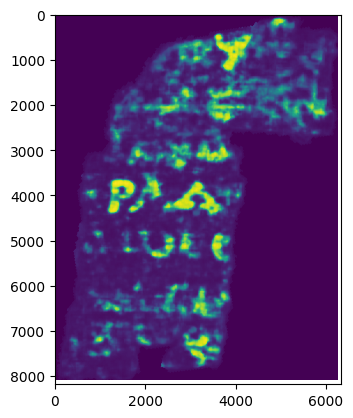

In [523]:
plt.imshow(final_mask_pred_raw)

In [512]:
# # apply final_threshold
# final_threshold = 2./5
# final_mask_pred = (final_mask_pred_raw > final_threshold).astype(int)

In [513]:
# final_mask_pred = torch.ones_like(gt_mask, dtype=torch.float32).cuda()

In [524]:
final_mask_pred_raw_cuda = torch.tensor(final_mask_pred_raw).cuda()

In [525]:
fbeta_best = 0
best_threshold = 0
for th in np.arange(0.05, 1.00, 0.01):
    fbeta = fbeta_score(final_mask_pred_raw_cuda, gt_mask, th).item()
    if fbeta > fbeta_best:
        fbeta_best = fbeta
        best_threshold = th
print(fbeta_best, best_threshold)

0.621433675289154 0.5400000000000001


: 

# Summary:

Best model performance: 0.6343


## All models


- Average of all probs:
    - print(fbeta_best, best_threshold) -> 0.62571 0.5400
- Majority vote:
    - print(fbeta_best, best_threshold) -> 0.603 0.4000


## Only models 2, 3, 4:

- Average of all probs:
    - print(fbeta_best, best_threshold) -> 0.63267 0.530
- Majority vote:
    - print(fbeta_best, best_threshold) -> 0.62415 0.34


## Only models 3, 4 (two best models):

- Average of all probs:
    - print(fbeta_best, best_threshold) -> 0.63195 0.580




## Only models 1, 2 (one trained with BCE, one with Focal loss)

Both have 0.56 Fbeta score.

- Average of all probs:
    - print(fbeta_best, best_threshold) -> 0.5675 0.0.48

In [398]:
# stride 2: 
# stride 5: 0.5288561582565308 0.6700000000000002


